# RP3 Strategy
Classic volatility targetted risk premia strategy using 3 instruments

Define imports and strategy parameters

In [190]:
import datetime
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

# Map asset class to instrument
equity_ticker = 'VDNR.L'
bond_ticker = 'IBTL.L'
gold_ticker = 'SGLN.L'
universe_tickers = [equity_ticker, bond_ticker, gold_ticker]

# Volatility targets for each asset class
equity_vol_target = 0.03
bond_vol_target = 0.03
gold_vol_target = 0.03

# Calendar days to load data for each asset class
hist_price_period_days = 365

# Day periods to use for volatility estimation
vol_forecast_period_days = 60

portfolio_value = 1000

Load historic adjusted close prices for our universe for last x days covering the volatility forecast period

In [191]:
# Set period to load data, noting these are calendar days not trading days
period = datetime.datetime.utcnow()
period_start = period - datetime.timedelta(days=hist_price_period_days)

# Get daily adjusted close data from Yahoo Finance for our universe
prices_df = pdr.get_data_yahoo(universe_tickers, start=period_start, end=period)[['Adj Close']]

# Standardize names
prices_df = prices_df.rename_axis(columns={'Attributes': 'attribute', 'Symbols': 'ticker'})
prices_df = prices_df.rename_axis(index={'Date': 'date'})
prices_df = prices_df.rename(columns={'Adj Close': 'price'})
print(prices_df.index.names)
print(prices_df.columns)

# Save price data to local feather file
feather_prep_df = prices_df.reset_index()
feather_prep_df.columns = feather_prep_df.columns.map(str)
feather_prep_df.to_feather("./prices.feather")

prices_df.tail(5)


['date']
MultiIndex([('price', 'VDNR.L'),
            ('price', 'IBTL.L'),
            ('price', 'SGLN.L')],
           names=['attribute', 'ticker'])


attribute        price                    
ticker          VDNR.L      IBTL.L  SGLN.L
date                                      
2022-08-17  104.230003  353.149994  2853.0
2022-08-18  104.544998  356.899994  2860.0
2022-08-19  103.157501  354.649994  2885.0
2022-08-22  101.510002  354.299988  2875.5
2022-08-23  101.129997  355.755005  2879.0

Enrich our dataframe of historic prices with further metrics required by the strategy

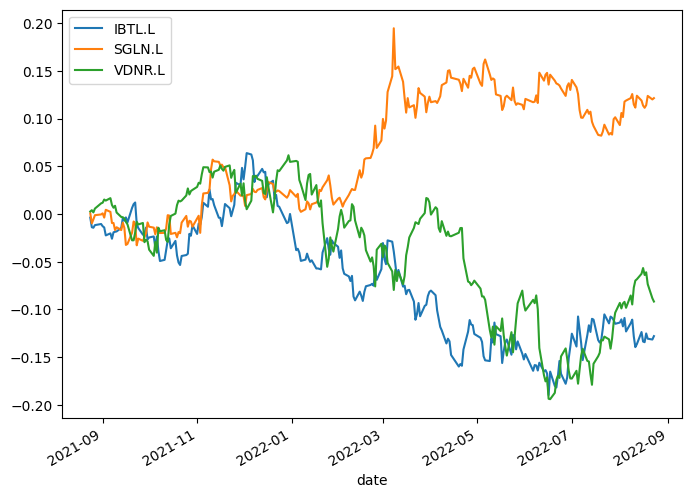

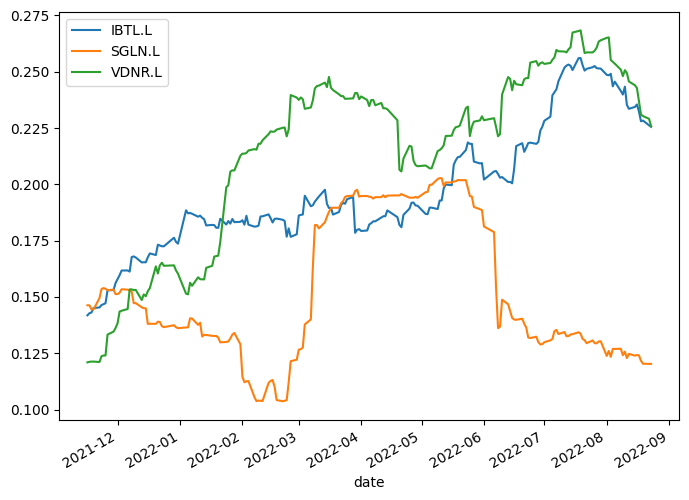

In [192]:
for ticker in universe_tickers:
    # Calculate total returns
    prices_df['return', ticker] = prices_df['price', ticker].pct_change()
    prices_df['log_return', ticker] = np.log(prices_df['price', ticker]/prices_df['price', ticker].shift(1))
    prices_df['cum_return', ticker] = (1 + prices_df['return', ticker]).cumprod() - 1
    prices_df['cum_log_return', ticker] = prices_df['log_return', ticker].cumsum()

    # Calculate rolling annual volatility for key periods
    prices_df['rolling_ann_vol', ticker] = prices_df['log_return', ticker].rolling(vol_forecast_period_days).std() * math.sqrt(252)
    prices_df['rolling_30d_ann_vol', ticker] = prices_df['log_return', ticker].rolling(30).std() * math.sqrt(252)
    prices_df['rolling_60d_ann_vol', ticker] = prices_df['log_return', ticker].rolling(60).std() * math.sqrt(252)
    prices_df['rolling_90d_ann_vol', ticker] = prices_df['log_return', ticker].rolling(90).std() * math.sqrt(252)  

prices_df = prices_df.sort_index(axis='columns', level=1)

prices_df['cum_return'].plot(figsize=(8,6))
plt.legend(loc=2)

prices_df['rolling_60d_ann_vol'].plot(figsize=(8, 6))
plt.legend(loc=2)


Now compute unconstrained position sizes based on annualized volatility for each instrument

In [195]:

latest_prices_df = prices_df.tail(1)
print(latest_prices_df.iloc[0])

last_price = latest_prices_df['price', 'VDNR.L'].values[0]
vol = latest_prices_df['rolling_ann_vol', 'VDNR.L'].values[0]
size = (equity_vol_target / vol) * (portfolio_value / last_price)


print(last_price)
print(vol)
print(size)



attribute            ticker
cum_log_return       IBTL.L      -0.136902
cum_return           IBTL.L      -0.127945
log_return           IBTL.L       0.004098
price                IBTL.L     355.755005
return               IBTL.L       0.004107
rolling_30d_ann_vol  IBTL.L       0.167679
rolling_60d_ann_vol  IBTL.L       0.225551
rolling_90d_ann_vol  IBTL.L       0.226999
rolling_ann_vol      IBTL.L       0.225551
cum_log_return       SGLN.L       0.114705
cum_return           SGLN.L       0.121543
log_return           SGLN.L       0.001216
price                SGLN.L    2879.000000
return               SGLN.L       0.001217
rolling_30d_ann_vol  SGLN.L       0.108701
rolling_60d_ann_vol  SGLN.L       0.120271
rolling_90d_ann_vol  SGLN.L       0.124788
rolling_ann_vol      SGLN.L       0.120271
cum_log_return       VDNR.L      -0.096159
cum_return           VDNR.L      -0.091681
log_return           VDNR.L      -0.003751
price                VDNR.L     101.129997
return               VDNR.